In [1]:
import scanpy as sc
import scirpy as ir
import pandas as pd
import torch
import yaml

In [2]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
experiment_name = 'example'
with open(f'../config/{experiment_name}.yaml') as file:
     params = yaml.load(file, Loader=yaml.FullLoader)
params

{'seq_model_arch': 'dummy',
 'seq_model_hyperparams': {'stride': 1, 'pad': 1, 'kernel_size': 3},
 'zdim': 32,
 'hdim': 256,
 'activation': 'relu',
 'output_activation': 'linear',
 'dropout': 0.2,
 'batch_norm': True,
 'gene_hidden': [512],
 'shared_hidden': [64]}

# Load dataset

### Wu 2020 3k (toy dataset from Scirpy)

In [5]:
wu2020 = sc.read_h5ad('../data/Wu_2020/wu2020_3k.h5ad')
wu2020

AnnData object with n_obs × n_vars = 3000 × 30727
    obs: 'cluster_orig', 'patient', 'sample', 'source', 'clonotype_orig', 'multi_chain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'has_ir', 'batch'
    var: 'gene_ids', 'feature_types'
    obsm: 'X_umap_orig'

In [6]:
pd.set_option('display.max_columns', None)
wu2020.obs

,cluster_orig,patient,sample,source,clonotype_orig,multi_chain,IR_VJ_1_locus,IR_VJ_2_locus,IR_VDJ_1_locus,IR_VDJ_2_locus,IR_VJ_1_cdr3,IR_VJ_2_cdr3,IR_VDJ_1_cdr3,IR_VDJ_2_cdr3,IR_VJ_1_junction_ins,IR_VJ_2_junction_ins,IR_VDJ_1_junction_ins,IR_VDJ_2_junction_ins,IR_VJ_1_expr,IR_VJ_2_expr,IR_VDJ_1_expr,IR_VDJ_2_expr,IR_VJ_1_v_gene,IR_VJ_2_v_gene,IR_VDJ_1_v_gene,IR_VDJ_2_v_gene,IR_VJ_1_d_gene,IR_VJ_2_d_gene,IR_VDJ_1_d_gene,IR_VDJ_2_d_gene,IR_VJ_1_j_gene,IR_VJ_2_j_gene,IR_VDJ_1_j_gene,IR_VDJ_2_j_gene,IR_VJ_1_c_gene,IR_VJ_2_c_gene,IR_VDJ_1_c_gene,IR_VDJ_2_c_gene,IR_VJ_1_cdr3_nt,IR_VJ_2_cdr3_nt,IR_VDJ_1_cdr3_nt,IR_VDJ_2_cdr3_nt,has_ir,batch
LN1_GTAGGCCAGCGTAGTG-1-19,4.4-FOS,Lung1,LN1,NAT,lung1.tn.C223,False,nan,nan,TRB,TRB,None,None,CASSLMRLAGDTQYF,CASRLAVLSTSGSVGETQYF,None,None,None,None,NaN,nan,3.0,2.0,nan,nan,TRBV7-2,TRBV12-3,NaN,nan,TRBD2,TRBD2,nan,nan,TRBJ2-3,TRBJ2-5,nan,nan,TRBC2,TRBC2,None,None,TGTGCCAGCAGCTTAATGCGGCTAGCGGGAGATACGCAGTATTTT,TGTGCAAGTCGCTTAGCGGTTTTATCGACTAGCGGGAGTGTCGGAG...,True,19
RN2_AGAGCGACAGATTGCT-1-27,4.4-FOS,Renal2,RN2,NAT,renal2.tnb.C1362,False,TRA,nan,TRB,nan,CAVRGNNNARLMF,None,CASSFGTVAEAFF,None,None,None,None,None,1.0,nan,4.0,nan,TRAV8-6,nan,TRBV7-9,nan,None,nan,None,nan,TRAJ31,nan,TRBJ1-1,nan,TRAC,nan,TRBC1,nan,TGTGCTGTGAGGGGGAATAACAATGCCAGACTCATGTTT,None,TGTGCCAGCAGCTTTGGAACGGTGGCTGAAGCTTTCTTT,None,True,27
LN1_GTCATTTCAATGAAAC-1-19,8.2-Tem,Lung1,LN1,NAT,lung1.tn.C25,False,TRA,nan,TRB,nan,CAVRLGNQFYF,None,CSARDGGGGNTEAFF,None,None,None,None,None,2.0,nan,6.0,nan,TRAV21,nan,TRBV20-1,nan,None,nan,TRBD2,nan,TRAJ49,nan,TRBJ1-1,nan,TRAC,nan,TRBC1,nan,TGTGCTGTGAGGTTGGGTAACCAGTTCTATTTT,None,TGCAGTGCTAGAGATGGAGGGGGGGGGAACACTGAAGCTTTCTTT,None,True,19
LN2_GACACGCAGGTAGCTG-2-2,8.6-KLRB1,Lung2,LN2,NAT,lung2.tn.C2452,False,nan,nan,TRB,nan,None,None,CASSQGQGQDFNYEQYF,None,None,None,None,None,NaN,nan,15.0,nan,nan,nan,TRBV4-2,nan,NaN,nan,TRBD1,nan,nan,nan,TRBJ2-7,nan,nan,nan,TRBC2,nan,None,None,TGTGCCAGCAGCCAAGGTCAGGGACAGGATTTTAACTACGAGCAGT...,None,True,2
LN2_GCACTCTCAGGGATTG-2-2,4.4-FOS,Lung2,LN2,NAT,lung2.tn.C5631,False,TRA,nan,TRB,nan,CAASDPTVEAGTALIF,None,CASSLTVNTEAFF,None,None,None,None,None,4.0,nan,26.0,nan,TRAV23DV6,nan,TRBV7-2,nan,None,nan,None,nan,TRAJ15,nan,TRBJ1-1,nan,TRAC,nan,TRBC1,nan,TGTGCAGCAAGCGACCCCACGGTCGAGGCAGGAACTGCTCTGATCTTT,None,TGTGCCAGCAGCTTGACCGTTAACACTGAAGCTTTCTTT,None,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RT3_GCAGTTAGTATGAAAC-1-6,4.2-RPL32,Renal3,RT3,Tumor,renal3.tnb.C176,False,TRA,nan,TRB,nan,CAAMDSNYQLIW,None,CATKDREDTGELFF,None,None,None,None,None,1.0,nan,2.0,nan,TRAV1-2,nan,TRBV6-4,nan,None,nan,TRBD1,nan,TRAJ33,nan,TRBJ2-2,nan,TRAC,nan,TRBC2,nan,TGTGCTGCGATGGATAGCAACTATCAGTTAATCTGG,None,TGTGCCACCAAGGACAGGGAAGACACCGGGGAGCTGTTTTTT,None,True,6
LT1_GACGTGCTCTCAAGTG-1-24,8.2-Tem,Lung1,LT1,Tumor,lung1.tn.C151,False,TRA,nan,nan,nan,CAYRSSLGGATNKLIF,None,None,None,None,None,None,None,1.0,nan,NaN,nan,TRAV38-2DV8,nan,nan,nan,None,nan,nan,nan,TRAJ32,nan,nan,nan,TRAC,nan,nan,nan,TGTGCTTATAGGAGTTCCCTTGGTGGTGCTACAAACAAGCTCATCTTT,None,None,None,True,24
ET3_GCTGGGTAGACCTTTG-1-3,3.1-MT,Endo3,ET3,Tumor,endo3.tn.C76,False,nan,nan,TRB,nan,None,None,CASSRTGGDSGELFF,None,None,None,None,None,NaN,nan,6.0,nan,nan,nan,TRBV7-6,nan,NaN,nan,TRBD1,nan,nan,nan,TRBJ2-2,nan,nan,nan,TRBC2,nan,None,None,TGTGCCAGCAGCCGGACAGGGGGGGATTCCGGGGAGCTGTTTTTT,None,True,3
RT1_TAAGAGATCCTTAATC-1-8,4.5-IL6ST,Renal1,RT1,Tumor,renal1.tnb.C83,False,TRA,nan,TRB,nan,CAMSEISGGYNKLIF,None,CAWSDRSDEQYF,None,None,None,None,None,5.0,nan,4.0,nan,TRAV12-3,nan,TRBV30,nan,None,nan,TRBD1,nan,TRAJ4,nan,TRBJ2-7,nan,TRAC,nan,TRBC2,nan,TGTGCAATGAGCGAGATTTCTGGTGGCTACAATAAGCTGATTTTT,None,TGTGCCTGGAGTGACAGGTCAGACGAGCAGTACTTC,None,True,8


In [7]:
sc.pp.filter_genes(wu2020, min_cells=50)
sc.pp.filter_cells(wu2020, min_genes=100)
wu2020

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 3000 × 8587
    obs: 'cluster_orig', 'patient', 'sample', 'source', 'clonotype_orig', 'multi_chain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'has_ir', 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
    obsm: 'X_umap_orig'

### BCC Dataset

In [8]:
bcc = sc.read_h5ad('../data/BCC_Yost_2018/bcc_tcr_and_gene.h5ad')
bcc

AnnData object with n_obs × n_vars = 53030 × 23309
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'patient_tcr', 'treatment_tcr', 'cluster_tcr', 'UMAP1_tcr', 'UMAP2_tcr'

In [9]:
sc.pp.filter_genes(bcc, min_cells=2000)
sc.pp.filter_cells(bcc, min_genes=2000)
bcc

AnnData object with n_obs × n_vars = 14214 × 9038
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'patient_tcr', 'treatment_tcr', 'cluster_tcr', 'UMAP1_tcr', 'UMAP2_tcr', 'n_genes'
    var: 'n_cell

In [10]:
# Filter samples without IR and multichain
bcc = bcc[bcc.obs['has_ir'] == 'True']
bcc = bcc[bcc.obs['multi_chain'] != 'True']
bcc

View of AnnData object with n_obs × n_vars = 6275 × 9038
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'patient_tcr', 'treatment_tcr', 'cluster_tcr', 'UMAP1_tcr', 'UMAP2_tcr', 'n_genes'
    var: 

### Create inner join between gene expression
Filter annData based on inner join and change order to be the same

In [11]:
inner_join = list(set(bcc.var.index.to_list()) & set(wu2020.var.index.to_list()))
inner_join

['SPRYD3',
 'TYW5',
 'NSMCE1',
 'DRG2',
 'TSEN15',
 'LCMT1',
 'MESDC1',
 'PDIA4',
 'GRAMD1A',
 'TRIM38',
 'LXN',
 'CROCC',
 'ANXA2',
 'ZNF512',
 'LAYN',
 'PIK3C2A',
 'FBXL20',
 'AHSA1',
 'PELO',
 'RNF168',
 'ABCA7',
 'RPS26',
 'PORCN',
 'PRPF38A',
 'PHF11',
 'NDUFB2',
 'ACTR2',
 'SHKBP1',
 'UGGT1',
 'TIMM44',
 'DLG1',
 'HDDC3',
 'SSBP4',
 'FAM126A',
 'LINC00094',
 'NUDT5',
 'RPS6KA5',
 'NFE2L2',
 'MCFD2',
 'TPRA1',
 'ZNF808',
 'ZNF302',
 'IFI6',
 'URI1',
 'TSEN54',
 'ERLIN2',
 'RPS6KC1',
 'CNP',
 'PET100',
 'CD2AP',
 'MGST2',
 'STRBP',
 'ZNF350',
 'USP42',
 'CFAP36',
 'MVP',
 'PQLC3',
 'ANAPC2',
 'PET117',
 'STAT5A',
 'SELPLG',
 'PRPF3',
 'MT2A',
 'OTUD6B',
 'PRMT5',
 'ZFYVE28',
 'GTF2E2',
 'ALDH3A2',
 'MAGED2',
 'DYNC1LI1',
 'IL6ST',
 'SRM',
 'MAP1LC3B',
 'BTN2A1',
 'CHCHD7',
 'TTN-AS1',
 'CBX3',
 'FAM177A1',
 'CD58',
 'GNPDA1',
 'ATP5EP2',
 'ABRACL',
 'CPNE7',
 'VAT1',
 'ID3',
 'LIN54',
 'PRUNE',
 'CAMK1D',
 'TPM1',
 'ABCC5',
 'CHURC1',
 'TACO1',
 'ZBTB8OS',
 'POR',
 'UROS',
 'YBX3',

In [12]:
wu2020 = wu2020[:, inner_join]
wu2020.var

,gene_ids,feature_types,n_cells
SPRYD3,GeneID:84926,Gene Expression,204
TYW5,GeneID:129450,Gene Expression,72
NSMCE1,GeneID:197370,Gene Expression,383
DRG2,GeneID:1819,Gene Expression,248
TSEN15,GeneID:116461,Gene Expression,318
...,...,...,...
COX6A1,GeneID:1337,Gene Expression,1732
NACA2,GeneID:342538,Gene Expression,140
POU2F1,GeneID:5451,Gene Expression,57
ABHD2,GeneID:11057,Gene Expression,113


In [13]:
bcc = bcc[:, inner_join]
bcc.var

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,n_cells
gene_ids,
SPRYD3,5773
TYW5,3731
NSMCE1,11088
DRG2,7760
TSEN15,7468
...,...
COX6A1,44942
NACA2,2674
POU2F1,2827


### Some Preprocessing to represent TCR sequence in a certain format
e.g. one-hot-encoding, hardcoded embedding

In [14]:
# This example just copies IR_VDJ_1_cdr3 over
wu2020.obs['tcr_seq'] = wu2020.obs['IR_VDJ_1_cdr3']

Trying to set attribute `.obs` of view, copying.


In [15]:
bcc.obs['tcr_seq'] = bcc.obs['IR_VDJ_1_cdr3']

Trying to set attribute `.obs` of view, copying.


In [16]:
wu2020.obs['tcr_seq'].str.len().max()

23

In [17]:
bcc.obs['tcr_seq'].str.len().max()

22

In [18]:
# Get unique list of proteins
tokenized_aa = wu2020.obs['tcr_seq'].str.split(pat='\s*')
tokenized_aa = [x for sublist in tokenized_aa for x in sublist]
tokenized_aa = set(tokenized_aa)
tokenized_aa  # TODO remove '' character that is a padding

{'',
 'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y',
 'e',
 'n',
 'o'}

In [19]:
tokenized_aa = bcc.obs['tcr_seq'].str.split(pat='\s*')
tokenized_aa = [x for sublist in tokenized_aa for x in sublist]
set(tokenized_aa)

{'',
 'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y',
 'e',
 'n',
 'o'}

# Initialize model

In [20]:
params

{'seq_model_arch': 'dummy',
 'seq_model_hyperparams': {'stride': 1, 'pad': 1, 'kernel_size': 3},
 'zdim': 32,
 'hdim': 256,
 'activation': 'relu',
 'output_activation': 'linear',
 'dropout': 0.2,
 'batch_norm': True,
 'gene_hidden': [512],
 'shared_hidden': [64]}

In [21]:
model = tcr.models.joint_model.JointModel(
    adatas=[wu2020, bcc],  # adatas containing gene expression and TCR-seq
    names=['wu2020', 'bcc'], 
    seq_model_arch=params['seq_model_arch'],  # seq model architecture
    seq_model_hyperparams=params['seq_model_hyperparams'],  # dict of seq model hyperparameters
    zdim=params['zdim'],  # zdim
    hdim=params['hdim'],  # hidden dimension of scRNA and seq encoders
    activation=params['activation'],  # activation function of autoencoder hidden layers
    output_activation=params['output_activation'],  # output activation of scRNA decoder
    dropout=params['dropout'],
    batch_norm=params['batch_norm'],
    gene_hidden=[512],  # hidden layers of gene encoder / decoder
    shared_hidden=[64],  # hidden layers of shared encoder / decoder
    gene_layers=[],  # [] or list of str for layer keys of each dataset
    seq_keys=[],  # [] or list of str for seq keys of each dataset
    device=None  # torch.device
)

In [22]:
model.model

JointModelTorch(
  (seq_encoder): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=7719, out_features=512, bias=False)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=False)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (seq_decoder): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=False)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=

In [23]:
model.train(
    experiment_name=experiment_name,
    n_iters=None,
    n_epochs=200,
    batch_size=128,
    lr=1e-3,
    losses=['MSE', 'CE'],  # list of losses for each modality: losses[0] := scRNA, losses[1] := TCR
    loss_weights=[],  # [] or list of floats storing weighting of loss in order [scRNA, TCR, KLD]
    val_split=0.1,
    validate_every=10,
    print_every=10,
    num_workers=0,
    verbose=2  # 0: only tdqm progress bar, 1: val loss, 2: train and val loss
)

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Epoch:   0%|█▎                                                                                                                                                                                                                                                                              | 1/200 [00:03<12:27,  3.76s/it]

Train Loss: 58.25779724121094
Train scRNA Loss: 28.698808670043945
Train TCR Loss: 28.57772445678711
Train KLD Loss: 0.9812608361244202

Val Loss: 42.8365364074707
Val scRNA Loss: 20.08122444152832
Val TCR Loss: 20.064868927001953
Val KLD Loss: 2.6904425621032715


Epoch:   6%|██████████████▉                                                                                                                                                                                                                                                                | 11/200 [00:12<02:55,  1.08it/s]

Train Loss: 23.270776748657227
Train scRNA Loss: 10.154157638549805
Train TCR Loss: 10.206930160522461
Train KLD Loss: 2.909684419631958

Val Loss: 23.087480545043945
Val scRNA Loss: 10.095131874084473
Val TCR Loss: 10.13378620147705
Val KLD Loss: 2.85856032371521


Epoch:  10%|████████████████████████████▍                                                                                                                                                                                                                                                  | 21/200 [00:20<02:35,  1.15it/s]

Train Loss: 22.838041305541992
Train scRNA Loss: 9.945146560668945
Train TCR Loss: 9.962688446044922
Train KLD Loss: 2.930205821990967

Val Loss: 22.293325424194336
Val scRNA Loss: 9.675859451293945
Val TCR Loss: 9.713472366333008
Val KLD Loss: 2.903993606567383


Epoch:  16%|██████████████████████████████████████████                                                                                                                                                                                                                                     | 31/200 [00:29<02:20,  1.20it/s]

Train Loss: 22.637617111206055
Train scRNA Loss: 9.897940635681152
Train TCR Loss: 9.91652774810791
Train KLD Loss: 2.8231513500213623

Val Loss: 22.83880615234375
Val scRNA Loss: 10.054981231689453
Val TCR Loss: 10.097381591796875
Val KLD Loss: 2.6864426136016846


Epoch:  20%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                       | 41/200 [00:37<02:12,  1.20it/s]

Train Loss: 22.272602081298828
Train scRNA Loss: 9.717833518981934
Train TCR Loss: 9.73674201965332
Train KLD Loss: 2.8180229663848877

Val Loss: 22.519853591918945
Val scRNA Loss: 9.814885139465332
Val TCR Loss: 9.87460708618164
Val KLD Loss: 2.83035945892334


Epoch:  26%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                          | 51/200 [00:45<02:04,  1.20it/s]

Train Loss: 22.32014274597168
Train scRNA Loss: 9.721471786499023
Train TCR Loss: 9.73346996307373
Train KLD Loss: 2.865203619003296

Val Loss: 22.565935134887695
Val scRNA Loss: 9.989202499389648
Val TCR Loss: 10.011283874511719
Val KLD Loss: 2.5654470920562744


Epoch:  30%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 61/200 [00:54<02:01,  1.15it/s]

Train Loss: 22.14989471435547
Train scRNA Loss: 9.612173080444336
Train TCR Loss: 9.648694038391113
Train KLD Loss: 2.8890278339385986

Val Loss: 22.26697540283203
Val scRNA Loss: 9.788387298583984
Val TCR Loss: 9.849139213562012
Val KLD Loss: 2.629448413848877


Epoch:  36%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 71/200 [01:02<01:47,  1.20it/s]

Train Loss: 21.984670639038086
Train scRNA Loss: 9.564512252807617
Train TCR Loss: 9.598816871643066
Train KLD Loss: 2.821342706680298

Val Loss: 22.75493621826172
Val scRNA Loss: 10.247000694274902
Val TCR Loss: 10.267921447753906
Val KLD Loss: 2.2400143146514893


Epoch:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 81/200 [01:10<01:43,  1.15it/s]

Train Loss: 21.862985610961914
Train scRNA Loss: 9.441435813903809
Train TCR Loss: 9.497395515441895
Train KLD Loss: 2.9241528511047363

Val Loss: 21.791627883911133
Val scRNA Loss: 9.548969268798828
Val TCR Loss: 9.596911430358887
Val KLD Loss: 2.6457462310791016


Epoch:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 91/200 [01:19<01:35,  1.15it/s]

Train Loss: 21.89640998840332
Train scRNA Loss: 9.421276092529297
Train TCR Loss: 9.469964981079102
Train KLD Loss: 3.0051698684692383

Val Loss: 21.547950744628906
Val scRNA Loss: 9.454641342163086
Val TCR Loss: 9.47910213470459
Val KLD Loss: 2.614206552505493


Epoch:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 101/200 [01:27<01:22,  1.19it/s]

Train Loss: 21.60262680053711
Train scRNA Loss: 9.331931114196777
Train TCR Loss: 9.372740745544434
Train KLD Loss: 2.897951364517212

Val Loss: 22.096500396728516
Val scRNA Loss: 9.710524559020996
Val TCR Loss: 9.75879955291748
Val KLD Loss: 2.6271770000457764


Epoch:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 111/200 [01:35<01:14,  1.20it/s]

Train Loss: 21.20696449279785
Train scRNA Loss: 9.155133247375488
Train TCR Loss: 9.177685737609863
Train KLD Loss: 2.8741462230682373

Val Loss: 23.048904418945312
Val scRNA Loss: 10.189436912536621
Val TCR Loss: 10.225790023803711
Val KLD Loss: 2.633676290512085


Epoch:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 121/200 [01:43<01:06,  1.20it/s]

Train Loss: 21.360992431640625
Train scRNA Loss: 9.132265090942383
Train TCR Loss: 9.150193214416504
Train KLD Loss: 3.0785343647003174

Val Loss: 22.343318939208984
Val scRNA Loss: 9.855554580688477
Val TCR Loss: 9.857903480529785
Val KLD Loss: 2.6298611164093018


Epoch:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 131/200 [01:52<00:57,  1.20it/s]

Train Loss: 21.250675201416016
Train scRNA Loss: 9.134183883666992
Train TCR Loss: 9.170398712158203
Train KLD Loss: 2.9460911750793457

Val Loss: 21.708805084228516
Val scRNA Loss: 9.468488693237305
Val TCR Loss: 9.50881290435791
Val KLD Loss: 2.7315049171447754


Epoch:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 141/200 [02:00<00:49,  1.20it/s]

Train Loss: 21.24146270751953
Train scRNA Loss: 9.058241844177246
Train TCR Loss: 9.068779945373535
Train KLD Loss: 3.114447832107544

Val Loss: 22.035112380981445
Val scRNA Loss: 9.619260787963867
Val TCR Loss: 9.660667419433594
Val KLD Loss: 2.7551825046539307


Epoch:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 151/200 [02:08<00:40,  1.20it/s]

Train Loss: 21.041404724121094
Train scRNA Loss: 8.911757469177246
Train TCR Loss: 8.953370094299316
Train KLD Loss: 3.1762795448303223

Val Loss: 21.665855407714844
Val scRNA Loss: 9.488422393798828
Val TCR Loss: 9.537373542785645
Val KLD Loss: 2.640061140060425


Epoch:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 161/200 [02:17<00:34,  1.14it/s]

Train Loss: 20.917476654052734
Train scRNA Loss: 8.889287948608398
Train TCR Loss: 8.913261413574219
Train KLD Loss: 3.1149306297302246

Val Loss: 20.646717071533203
Val scRNA Loss: 8.837501525878906
Val TCR Loss: 8.867234230041504
Val KLD Loss: 2.9419825077056885


Epoch:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 171/200 [02:25<00:24,  1.19it/s]

Train Loss: 20.636940002441406
Train scRNA Loss: 8.760488510131836
Train TCR Loss: 8.801259994506836
Train KLD Loss: 3.0752010345458984

Val Loss: 20.959074020385742
Val scRNA Loss: 8.996329307556152
Val TCR Loss: 9.028948783874512
Val KLD Loss: 2.933797836303711


Epoch:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 181/200 [02:33<00:15,  1.20it/s]

Train Loss: 20.473716735839844
Train scRNA Loss: 8.64869213104248
Train TCR Loss: 8.660658836364746
Train KLD Loss: 3.1643640995025635

Val Loss: 21.655975341796875
Val scRNA Loss: 9.377188682556152
Val TCR Loss: 9.365797996520996
Val KLD Loss: 2.9129862785339355


Epoch:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 191/200 [02:42<00:07,  1.19it/s]

Train Loss: 20.577083587646484
Train scRNA Loss: 8.691751480102539
Train TCR Loss: 8.704705238342285
Train KLD Loss: 3.180626153945923

Val Loss: 20.789804458618164
Val scRNA Loss: 8.842623710632324
Val TCR Loss: 8.875219345092773
Val KLD Loss: 3.071962594985962


Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:49<00:00,  1.18it/s]


In [24]:
model.history

,epoch,loss,scRNA_loss,TCR_loss,KLD_loss
0,0,342.692291,160.649796,160.518951,21.523540
1,10,184.699844,80.761055,81.070290,22.868483
2,20,178.346603,77.406876,77.707779,23.231949
3,30,182.710449,80.439850,80.779053,21.491541
4,40,180.158829,78.519081,78.996857,22.642876
5,50,180.527481,79.913620,80.090271,20.523577
6,60,178.135803,78.307098,78.793114,21.035587
7,70,182.039490,81.976006,82.143372,17.920115
8,80,174.333023,76.391754,76.775291,21.165970
9,90,172.383606,75.637131,75.832817,20.913652


# Predict

In [29]:
z = model.predict(adatas=[wu2020, bcc], names=['wu2020','bcc'], batch_size=64, num_workers=0, gene_layers=[], seq_keys=[])

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 198.55it/s]


In [26]:
z

AnnData object with n_obs × n_vars = 9275 × 32
    obs: 'barcode', 'dataset', 'batch'

In [27]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'dataset' as categorical


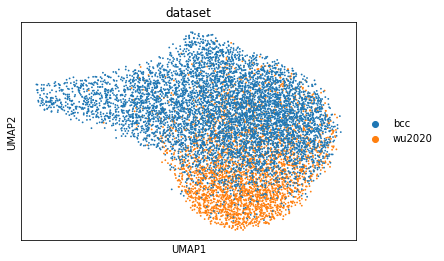

In [28]:
sc.pl.umap(z, color=['dataset'], ncols=1)